In [1]:
# coding=gbk
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

In [2]:
# 处理训练集和测试集文件
def deal_file(filename):
    # 读取CSV文件
    df = pd.read_csv(filename)

    # 创建nextlat和nextlon列，将下一行的lat和lon值移动到当前行
    df['nextlat'] = df['lat'].shift(-1)
    df['nextlon'] = df['lon'].shift(-1)

    # 去除最后一行（因为最后一行没有下一行的数据）
    df = df.iloc[:-1]

    # 保存结果到新的CSV文件
    parts=filename.split('.')
    new_filename=parts[0]+'_deal.'+parts[1]
    print(f"新文件名称：{new_filename}")
    df.to_csv(new_filename, index=False)
    return new_filename
    
train_file=deal_file('train.csv')
test_file=deal_file('test.csv')

新文件名称：train_deal.csv
新文件名称：test_deal.csv


In [3]:
# 读取训练集和测试集
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file,encoding='gbk')

# 定义特征列和标签列
features = ['mmsi', 'lat', 'lon', 'Sog', 'Cog', 'timestamp']
labels = ['nextlat', 'nextlon']

# 根据特征列和标签列选择输入和输出数据
X_train = train_data[features].values
Y_train = train_data[labels].values
X_test = test_data[features].values
Y_test = test_data[labels].values

In [4]:
# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaler1 = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
Y_train = scaler1.fit_transform(Y_train)
Y_test = scaler1.transform(Y_test)

# 将输入序列重塑为3D张量
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [5]:
# 测试数据反归一
scaler1.inverse_transform(Y_train)

array([[ 30.409912, 121.834347],
       [ 30.409468, 121.833942],
       [ 30.409068, 121.83357 ],
       ...,
       [ 30.39681 , 121.866107],
       [ 30.398063, 121.867738],
       [ 30.390193, 121.857385]])

In [6]:
# 定义LSTM模型
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=2))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])

# 训练和评估模型
# 添加验证集以监控过拟合
history = model.fit(X_train, Y_train, epochs=50, batch_size=64, verbose=1,validation_split=0.2)
# 显示模型结构
model.summary()
loss, acc = model.evaluate(X_train, Y_train, verbose=2)
print('Loss : {}, Accuracy: {}'.format(loss, acc * 100))

Epoch 1/50
249/249 [==============================] - 2s 2ms/step - loss: 0.0527 - acc: 0.9777 - val_loss: 0.0107 - val_acc: 0.8300
Epoch 2/50
249/249 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 0.9919 - val_loss: 0.0014 - val_acc: 0.9882
Epoch 3/50
249/249 [==============================] - 0s 2ms/step - loss: 8.9797e-04 - acc: 0.9942 - val_loss: 0.0014 - val_acc: 0.9900
Epoch 4/50
249/249 [==============================] - 0s 2ms/step - loss: 8.7375e-04 - acc: 0.9945 - val_loss: 0.0013 - val_acc: 0.9905
Epoch 5/50
249/249 [==============================] - 0s 2ms/step - loss: 8.5629e-04 - acc: 0.9947 - val_loss: 0.0013 - val_acc: 0.9905
Epoch 6/50
249/249 [==============================] - 0s 2ms/step - loss: 8.4536e-04 - acc: 0.9950 - val_loss: 0.0012 - val_acc: 0.9910
Epoch 7/50
249/249 [==============================] - 0s 2ms/step - loss: 8.4192e-04 - acc: 0.9950 - val_loss: 0.0012 - val_acc: 0.9915
Epoch 8/50
249/249 [==============================] - 0s

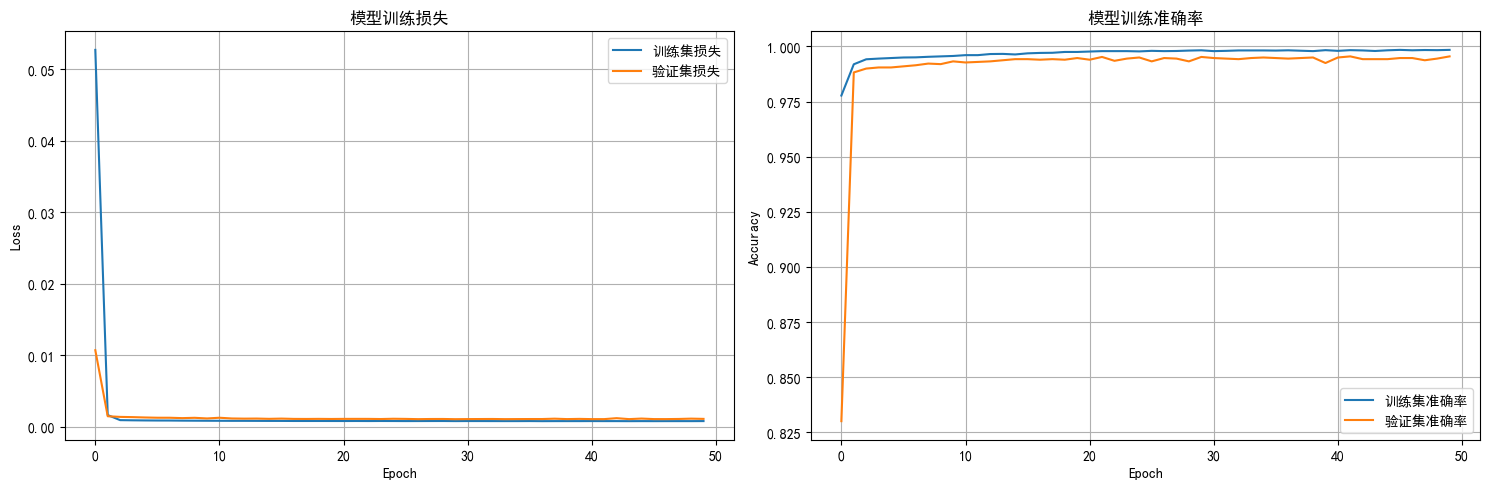

In [7]:
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 绘制训练过程
plt.figure(figsize=(15, 5))

# 损失函数曲线
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='训练集损失')
plt.plot(history.history['val_loss'], label='验证集损失')
plt.title('模型训练损失')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='训练集准确率')
plt.plot(history.history['val_acc'], label='验证集准确率')
plt.title('模型训练准确率')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# 对测试集进行预测
y_pred = model.predict(X_test)

# 评估模型准确率
score = model.evaluate(X_test, Y_test, batch_size=64, verbose=1)
print("Test accuracy:", score[1])

149/149 [==============================] - 0s 1ms/step - loss: 9.3744e-04 - acc: 0.9969
Test accuracy: 0.9968540072441101


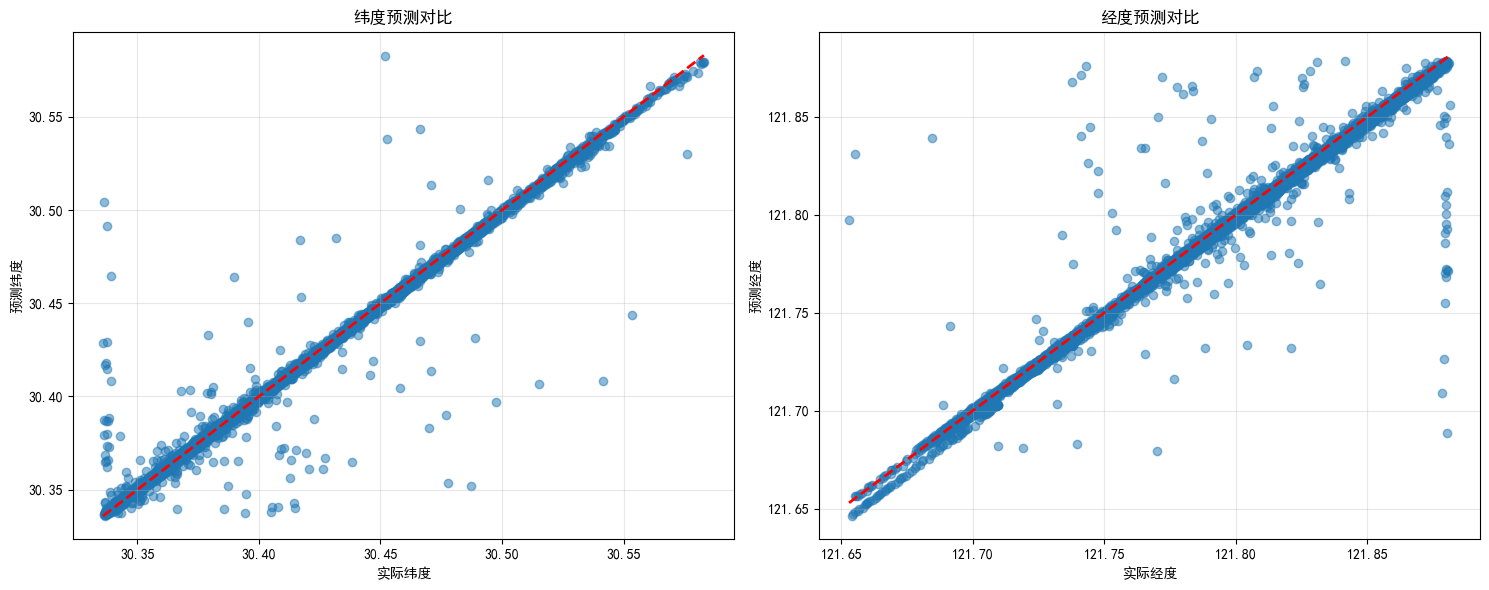

In [9]:
# 反归一化
y_test_original = scaler1.inverse_transform(Y_test)
y_pred_original = scaler1.inverse_transform(y_pred)

# 绘制经纬度预测对比
plt.figure(figsize=(15, 6))

# 纬度预测对比
plt.subplot(1, 2, 1)
plt.scatter(y_test_original[:, 0], y_pred_original[:, 0], alpha=0.5)
plt.plot([y_test_original[:, 0].min(), y_test_original[:, 0].max()], 
         [y_test_original[:, 0].min(), y_test_original[:, 0].max()], 'r--', lw=2)
plt.xlabel('实际纬度')
plt.ylabel('预测纬度')
plt.title('纬度预测对比')
plt.grid(True, alpha=0.3)

# 经度预测对比
plt.subplot(1, 2, 2)
plt.scatter(y_test_original[:, 1], y_pred_original[:, 1], alpha=0.5)
plt.plot([y_test_original[:, 1].min(), y_test_original[:, 1].max()], 
         [y_test_original[:, 1].min(), y_test_original[:, 1].max()], 'r--', lw=2)
plt.xlabel('实际经度')
plt.ylabel('预测经度')
plt.title('经度预测对比')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

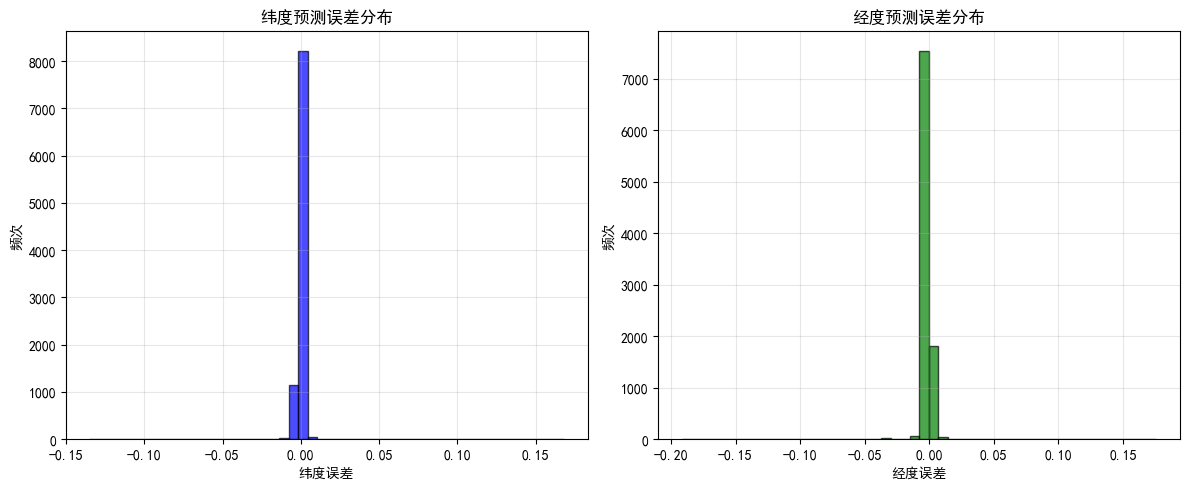

In [10]:
# 误差分布直方图
lat_errors = y_pred_original[:, 0] - y_test_original[:, 0]
lon_errors = y_pred_original[:, 1] - y_test_original[:, 1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(lat_errors, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('纬度误差')
plt.ylabel('频次')
plt.title('纬度预测误差分布')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(lon_errors, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('经度误差')
plt.ylabel('频次')
plt.title('经度预测误差分布')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
test_data2 = pd.read_csv('test.csv')
X_test2 = test_data2[features]

In [12]:
arr_list = []
for i in range(27, 88):
    if i == 82:
        continue
    test2 = X_test2.loc[X_test2['mmsi'] == i, :][-1:].values
    arr_list.append(test2[0])

# 将 arr_list 中的每个一维数组垂直堆叠在一起，形成一个二维数组
result = arr_list[0]
for i in range(1, len(arr_list)):
    result = np.vstack((result, arr_list[i]))

print(result)

[[2.70000000e+01 3.03383620e+01 1.21792343e+02 1.56000000e+01
  2.41000000e+02 1.54334514e+09]
 [2.80000000e+01 3.03718330e+01 1.21796000e+02 1.29000000e+01
  5.90000000e+01 1.53927390e+09]
 [2.90000000e+01 3.03408830e+01 1.21792200e+02 1.61000000e+01
  3.40000000e+01 1.53190755e+09]
 [3.00000000e+01 3.03798130e+01 1.21841482e+02 1.81000000e+01
  2.62000000e+02 1.53766957e+09]
 [3.10000000e+01 3.03716500e+01 1.21851550e+02 1.07000000e+01
  1.08000000e+02 1.54340696e+09]
 [3.20000000e+01 3.03653900e+01 1.21794258e+02 1.05000000e+01
  1.06000000e+02 1.54029419e+09]
 [3.30000000e+01 3.04041220e+01 1.21818743e+02 1.18000000e+01
  2.70000000e+02 1.54332025e+09]
 [3.40000000e+01 3.04025280e+01 1.21810697e+02 1.06000000e+01
  2.73000000e+02 1.53167152e+09]
 [3.50000000e+01 3.03399520e+01 1.21802618e+02 1.14000000e+01
  1.09000000e+02 1.54191123e+09]
 [3.60000000e+01 3.03779670e+01 1.21747133e+02 1.06000000e+01
  2.61000000e+02 1.53915227e+09]
 [3.70000000e+01 3.03665770e+01 1.21680765e+02 1.1

In [13]:
# 数据归一化
result = scaler.fit_transform(result)
print(result)
# 将输入序列重塑为3D张量
test2 = result.reshape((result.shape[0], 1, result.shape[1]))
print(test2)
# 预测每个船舶的经纬度
predictions2 = []
for i in range(test2.shape[0]):
    test_input2 = test2[i].reshape((1, 1, test2.shape[2]))
    prediction2 = model.predict(test_input2, verbose=0)
    predictions2.append(prediction2)
predictions2 = np.array(predictions2).reshape((-1, 2))
predictions2 = scaler1.inverse_transform(predictions2)
predictions2

[[0.         0.         0.57690611 0.66350711 0.6945245  0.41489005]
 [0.01666667 0.13681569 0.59544632 0.53554502 0.17002882 0.27019471]
 [0.03333333 0.01030481 0.57618113 0.68720379 0.09798271 0.00838877]
 [0.05       0.16943465 0.82603031 0.78199052 0.75504323 0.21317552]
 [0.06666667 0.13606766 0.87707291 0.43127962 0.31123919 0.41708725]
 [0.08333333 0.11047935 0.58661475 0.42180095 0.3054755  0.30645674]
 [0.1        0.26879984 0.71074845 0.48341232 0.77809798 0.41400551]
 [0.11666667 0.26228423 0.66995696 0.42654028 0.78674352 0.        ]
 [0.13333333 0.00649927 0.62899816 0.46445498 0.31412104 0.36392787]
 [0.15       0.16188896 0.34770111 0.42654028 0.75216138 0.26587191]
 [0.16666667 0.11533132 0.01122958 0.46919431 0.22478386 0.26635427]
 [0.18333333 0.13974649 0.32829397 0.44549763 0.78674352 0.13415904]
 [0.2        0.33021995 0.73992507 0.41232227 0.2795389  0.29098567]
 [0.21666667 0.16502005 0.41530163 0.44075829 0.76657061 0.38278932]
 [0.23333333 0.2425984  0.61999929

array([[ 30.339525, 121.79202 ],
       [ 30.373734, 121.7959  ],
       [ 30.341745, 121.79714 ],
       [ 30.385717, 121.855705],
       [ 30.370764, 121.85885 ],
       [ 30.365316, 121.79086 ],
       [ 30.406305, 121.81815 ],
       [ 30.40459 , 121.81059 ],
       [ 30.338764, 121.80184 ],
       [ 30.378328, 121.732185],
       [ 30.366804, 121.65276 ],
       [ 30.373137, 121.72824 ],
       [ 30.420565, 121.824814],
       [ 30.379002, 121.74726 ],
       [ 30.400957, 121.79869 ],
       [ 30.40398 , 121.80857 ],
       [ 30.339653, 121.81447 ],
       [ 30.374739, 121.8543  ],
       [ 30.433441, 121.79297 ],
       [ 30.392979, 121.89709 ],
       [ 30.363333, 121.852585],
       [ 30.417362, 121.87485 ],
       [ 30.434153, 121.75077 ],
       [ 30.370249, 121.79923 ],
       [ 30.361979, 121.84256 ],
       [ 30.425167, 121.87948 ],
       [ 30.405745, 121.88359 ],
       [ 30.45189 , 121.80729 ],
       [ 30.35298 , 121.70652 ],
       [ 30.367996, 121.780106],
       [ 3

In [14]:
# 导入csv库
import csv
with open("submission.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    # 先写入columns_name
    writer.writerow(["mmsi", "lat", "lon"])
    # 预测结果
    for i in range(60):
        if i == 82:
            continue
        # 写入多行用writerows
        pred_lat = predictions2[i][0]
        pred_lon = predictions2[i][1]
        print(pred_lat,pred_lon)
        for j in range(6):
            writer.writerow([i+27, pred_lat, pred_lon])

30.339525 121.79202
30.373734 121.7959
30.341745 121.79714
30.385717 121.855705
30.370764 121.85885
30.365316 121.79086
30.406305 121.81815
30.40459 121.81059
30.338764 121.80184
30.378328 121.732185
30.366804 121.65276
30.373137 121.72824
30.420565 121.824814
30.379002 121.74726
30.400957 121.79869
30.40398 121.80857
30.339653 121.81447
30.374739 121.8543
30.433441 121.79297
30.392979 121.89709
30.363333 121.852585
30.417362 121.87485
30.434153 121.75077
30.370249 121.79923
30.361979 121.84256
30.425167 121.87948
30.405745 121.88359
30.45189 121.80729
30.35298 121.70652
30.367996 121.780106
30.38227 121.84022
30.38986 121.81054
30.406456 121.86325
30.344757 121.64692
30.449738 121.88061
30.498903 121.74154
30.387194 121.84224
30.371635 121.759766
30.413858 121.87616
30.398024 121.75557
30.340559 121.761635
30.338894 121.7624
30.359255 121.65942
30.362007 121.80099
30.350218 121.75915
30.366697 121.751884
30.362785 121.83789
30.362202 121.79069
30.496153 121.688416
30.502714 121.7092
3